### Question 2

Compared to fully connected neural networks, there are less weights in a convolutional neural network. 

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import autograd
import torch.nn.functional as F
import random

In [22]:
images1 = np.load("cs475_project_data/images.npy")
num_images, height, width = images1.shape
images1 = images1.reshape(num_images, height*width) #reshape
labels1 = np.load("cs475_project_data/labels.npy")

images = torch.from_numpy(images1)
labels = torch.from_numpy(labels1).type(torch.IntTensor) # make sure int values

images = images.type(torch.DoubleTensor)
images = (images - torch.mean(images))/torch.std(images)
# the above normalizes the data based on z score

In [23]:
# split data
train_data = images[:40000]
dev_data = images[40000:45000]
test_data = images[45000:]

train_labels = labels[:40000]
dev_labels = labels[40000:45000]
test_labels = labels[45000:]

HEIGHT = 26
WIDTH = 26
NUM_CLASSES = 5
NUM_OPT_STEPS = 2000

In [24]:
class TooSimpleConvNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 3x3 convolution that takes in an image with one channel
        # and outputs an image with 8 channels.
        self.conv1 = torch.nn.Conv2d(1, 8, kernel_size=3)
        # 3x3 convolution that takes in an image with 8 channels
        # and outputs an image with 16 channels. The output image
        # has approximately half the height and half the width
        # because of the stride of 2.
        self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=3, stride=2)
        # 1x1 convolution that takes in an image with 16 channels and
        # produces an image with 5 channels. Here, the 5 channels
        # will correspond to class scores.
        self.final_conv = torch.nn.Conv2d(16, 5, kernel_size=1)
    def forward(self, x):
        # Convolutions work with images of shape
        # [batch_size, num_channels, height, width]
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        x = F.relu(self.conv1(x)).clamp(min=0)
        x = F.relu(self.conv2(x)).clamp(min=0)
        n, c, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        x = self.final_conv(x).view(-1, NUM_CLASSES)
        return x

In [25]:
model = TooSimpleConvNN()

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=.01)

In [27]:
def train(batch_size):
    # model.train() puts our model in train mode, which can require different
    # behavior than eval mode (for example in the case of dropout).
    model.train()
    # i is is a 1-D array with shape [batch_size]
    i = np.random.choice(train_data.shape[0], size=batch_size, replace=False)
    temp = train_data.numpy()
    temp1 = train_labels.numpy()
    x = autograd.Variable(torch.from_numpy(temp[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(temp1[i].astype(np.int)))
    optimizer.zero_grad()
    y_hat_ = model(x)
    loss = F.cross_entropy(y_hat_, y)
    loss.backward()
    optimizer.step()
    return loss.data[0]

In [28]:
def approx_train_accuracy():
    i = np.random.choice(train_data.shape[0], size=1000, replace=False)
    tempy = train_data.numpy()
    tempy1 = train_labels.numpy()
    x = autograd.Variable(torch.from_numpy(tempy[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(tempy1[i].astype(np.int)))
    y_hat_ = model(x)
    #print(y)
    y = y.data.numpy()
    y_hat_ = y_hat_.data.numpy()
    y_hat_ = np.argmax(y_hat_, axis=1)
    #print(y_hat_)
    return (y == y_hat_).astype(np.float).mean()

def val_accuracy():
    i = np.random.choice(dev_data.shape[0], size=5000, replace=False)
    tempy2 = dev_data.numpy()
    tempy3 = dev_labels.numpy()
    x = autograd.Variable(torch.from_numpy(tempy2[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(tempy3[i].astype(np.int)))
    y_hat_ = model(x)
    #print(y)
    y = y.data.numpy()
    y_hat_ = y_hat_.data.numpy()
    y_hat_ = np.argmax(y_hat_, axis=1)
    #print(y_hat_)
    return (y == y_hat_).astype(np.float).mean()

In [9]:
train_accs, val_accs = [], []
iterations = []
print("Using model with initial, unadjusted optimizer and learning rate") #100, .01
for i in range(NUM_OPT_STEPS):
    train(10) #100, .01
    if i % 100 == 0:
        iterations.append(i)
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))

Using model with initial, unadjusted optimizer and learning rate
     0  0.20  0.19
   100  0.19  0.20
   200  0.37  0.38
   300  0.56  0.58
   400  0.58  0.59
   500  0.55  0.57
   600  0.62  0.63
   700  0.62  0.63
   800  0.65  0.67
   900  0.63  0.65
  1000  0.65  0.66
  1100  0.67  0.65
  1200  0.65  0.68
  1300  0.66  0.67
  1400  0.64  0.67
  1500  0.67  0.67
  1600  0.66  0.67
  1700  0.68  0.68
  1800  0.64  0.66
  1900  0.67  0.68


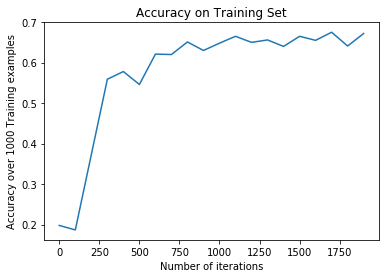

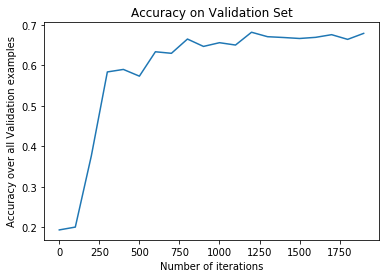

In [10]:
plt.plot(iterations, train_accs)
plt.title("Accuracy on Training Set")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy over 1000 Training examples")
plt.show()

plt.plot(iterations, val_accs)
plt.title("Accuracy on Validation Set")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy over all Validation examples")
plt.show()

In [29]:
train_accs, val_accs = [], []
iterations = []
NUM_OPT_STEPS = 2500
print("Using model with batch size of 100 and total steps of 2500 and learning rate of .01")
for i in range(NUM_OPT_STEPS):
    train(100)
    if i % 100 == 0:
        iterations.append(i)
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))

Using model with batch size of 100 and total steps of 2500 and learning rate of .01
     0  0.19  0.20
   100  0.56  0.56
   200  0.65  0.66
   300  0.63  0.68
   400  0.66  0.66
   500  0.75  0.75
   600  0.75  0.77
   700  0.80  0.78
   800  0.74  0.76
   900  0.76  0.78
  1000  0.79  0.77
  1100  0.78  0.80
  1200  0.79  0.79
  1300  0.79  0.79
  1400  0.79  0.78
  1500  0.82  0.80
  1600  0.80  0.79
  1700  0.78  0.81
  1800  0.80  0.82
  1900  0.78  0.81
  2000  0.77  0.80
  2100  0.80  0.80
  2200  0.82  0.81
  2300  0.79  0.80
  2400  0.78  0.81


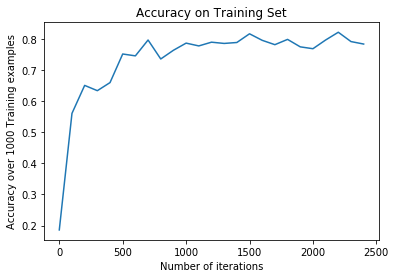

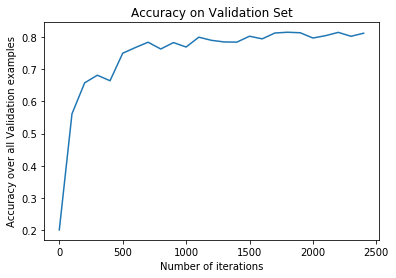

In [30]:
plt.plot(iterations, train_accs)
plt.title("Accuracy on Training Set")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy over 1000 Training examples")
plt.show()

plt.plot(iterations, val_accs)
plt.title("Accuracy on Validation Set")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy over all Validation examples")
plt.show()

The best validation accuracy I received was 82%. The batch size was 100 and the learning rate was .01. The number of optimization steps was 2500, and training took about 3-4 minutes.